In [261]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
%load_ext autoreload
%autoreload 2

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [262]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [441]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import _count_observations_by_pairs
from spatial_tools.graph.nhood import *

In [360]:
spatial_connectivity(adata, n_degree=3)

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Small test (edges, nodes, nodes-fast)

In [442]:
positions = np.arange(6)
leiden = np.array([1, 1, 1, 2, 2, 2])
conn = np.array([[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]])

print('connectivities')
print(conn)
print('leiden', leiden)
print('positions', positions)

connectivities
[[0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [1 1 1 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 0 0 0]]
leiden [1 1 1 2 2 2]
positions [0 1 2 3 4 5]


In [443]:
edges = _count_observations_by_pairs(conn, leiden, positions, count_option='edges')
edges.head()

,leiden.i,leiden.j,n.obs,mode,k
0,0,1,9,edges,0:1


In [444]:
nodes = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')
nodes.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,6,nodes,1:2


In [445]:
nodes_dev = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes-dev')
nodes_dev.head()

,leiden.i,leiden.j,n.obs,mode,k
0,0,1,3,nodes,0:1


When using nodes the output is as expected. The implementation based on nodes-fast returns the minimum number apparently
- This could be a minor modification somewhere
- Additionally np.meshgrid([x, y]) can be implemented for option='nodes', to avoid writing the function cartesian
    - A more detailed discussion in here
https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays

In [446]:
positions = np.arange(5)
leiden = np.array([1, 1, 2, 2, 2])
conn = np.array([[0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0]])

print('connectivities')
print(conn)
print('leiden', leiden)
print('positions', positions)

connectivities
[[0 0 1 1 1]
 [0 0 1 1 1]
 [0 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 0]]
leiden [1 1 2 2 2]
positions [0 1 2 3 4]


In [447]:
edges = _count_observations_by_pairs(conn, leiden, positions, count_option='edges')
edges.head()

,leiden.i,leiden.j,n.obs,mode,k
0,0,1,6,edges,0:1


In [448]:
nodes = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')
nodes.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


### Issue: here the nodes-dev should throw 5 but instead it throws 3. Probably it counts only one category (tbc)

In [449]:
nodes_fast = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes-dev')
nodes_fast.head()

,leiden.i,leiden.j,n.obs,mode,k
0,0,1,3,nodes,0:1


## Big test (10x visium data)

In [450]:
leiden = adata.obs['leiden']
conn = adata.obsp['spatial_connectivity']
N = adata.shape[0]
positions = np.arange(N) # .reshape(w, h)

This is for profiling the speed of functions and speeding up. Uncomment for checking

In [229]:
# %load_ext line_profiler

# %lprun -f permutation_test_leiden_pairs permutation_test_leiden_pairs(adata, n_permutations=10, count_option='edges')
# %lprun -f permutation_test_leiden_pairs permutation_test_leiden_pairs(adata, n_permutations=100, print_log_each=25)
# %lprun -f _count_observations_by_pairs _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')

In [451]:
%time permutation_test_leiden_pairs(adata, n_permutations=100, print_log_each=25, count_option='edges')
edges = adata.uns['nhood_permutation_test'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
25 out of 100 permutations
50 out of 100 permutations
75 out of 100 permutations
100 out of 100 permutations
CPU times: user 14 s, sys: 4.15 ms, total: 14 s
Wall time: 14.1 s


In [452]:
edges.shape
edges[(edges['k'] == '3:9') | (edges['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
56,3,9,129,edges,3:9,220,147,16.324031,38.04,5.572153
56,9,3,129,edges,9:3,220,147,16.324031,38.04,5.572153


In [453]:
%time permutation_test_leiden_pairs(adata, n_permutations=100, print_log_each=25, count_option='nodes')
nodes = adata.uns['nhood_permutation_test'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
25 out of 100 permutations
50 out of 100 permutations
75 out of 100 permutations
100 out of 100 permutations
CPU times: user 13.6 s, sys: 3.5 s, total: 17.1 s
Wall time: 17.2 s


In [454]:
nodes.shape
nodes[(nodes['k'] == '3:9') | (nodes['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
59,9,3,349,nodes,9:3,147,220,3.279986,322.66,8.030523
59,3,9,349,nodes,3:9,147,220,3.279986,322.66,8.030523


In [455]:
%time permutation_test_leiden_pairs(adata, n_permutations=100, print_log_each=25, count_option='nodes-dev')
nodes_dev = adata.uns['nhood_permutation_test'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
25 out of 100 permutations
50 out of 100 permutations
75 out of 100 permutations
100 out of 100 permutations
CPU times: user 14.3 s, sys: 6.24 ms, total: 14.3 s
Wall time: 14.4 s


In [456]:
nodes_dev.shape
nodes_dev[(nodes_dev['k'] == '3:9') | (nodes_dev['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
56,3,9,13,nodes,3:9,220,147,-1.631324,15.88,1.765437
56,9,3,13,nodes,9:3,220,147,-1.631324,15.88,1.765437


### Here we check whether the association between nodes and nodes-dev makes sense

Text(0, 0.5, '# obs (nodes-dev)')

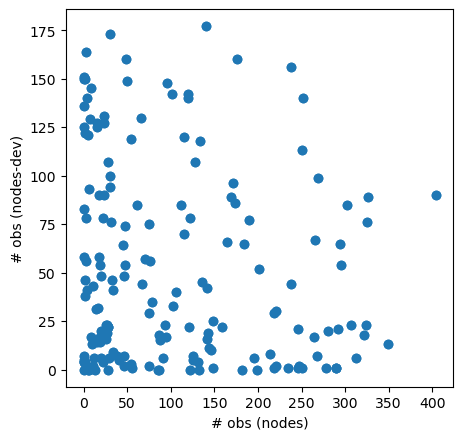

In [459]:
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [5, 5]
x = nodes.set_index('k')['n.obs'].to_dict()
y = nodes_dev.set_index('k')['n.obs'].to_dict()
v = pd.DataFrame(index=x.keys())
v['nodes'] = v.index.map(x)
v['nodes.dev'] = v.index.map(y)
plt.scatter(v['nodes'], v['nodes.dev'])
plt.xlabel('# obs (nodes)')
plt.ylabel('# obs (nodes-dev)')

Currently the running time is ~15-20s / 100 permutations. Therefore
- 1000 permutations would take ~150-200 s. 
- 10k permutations would take ~1500-2000 s.

In [460]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = [10, 15]

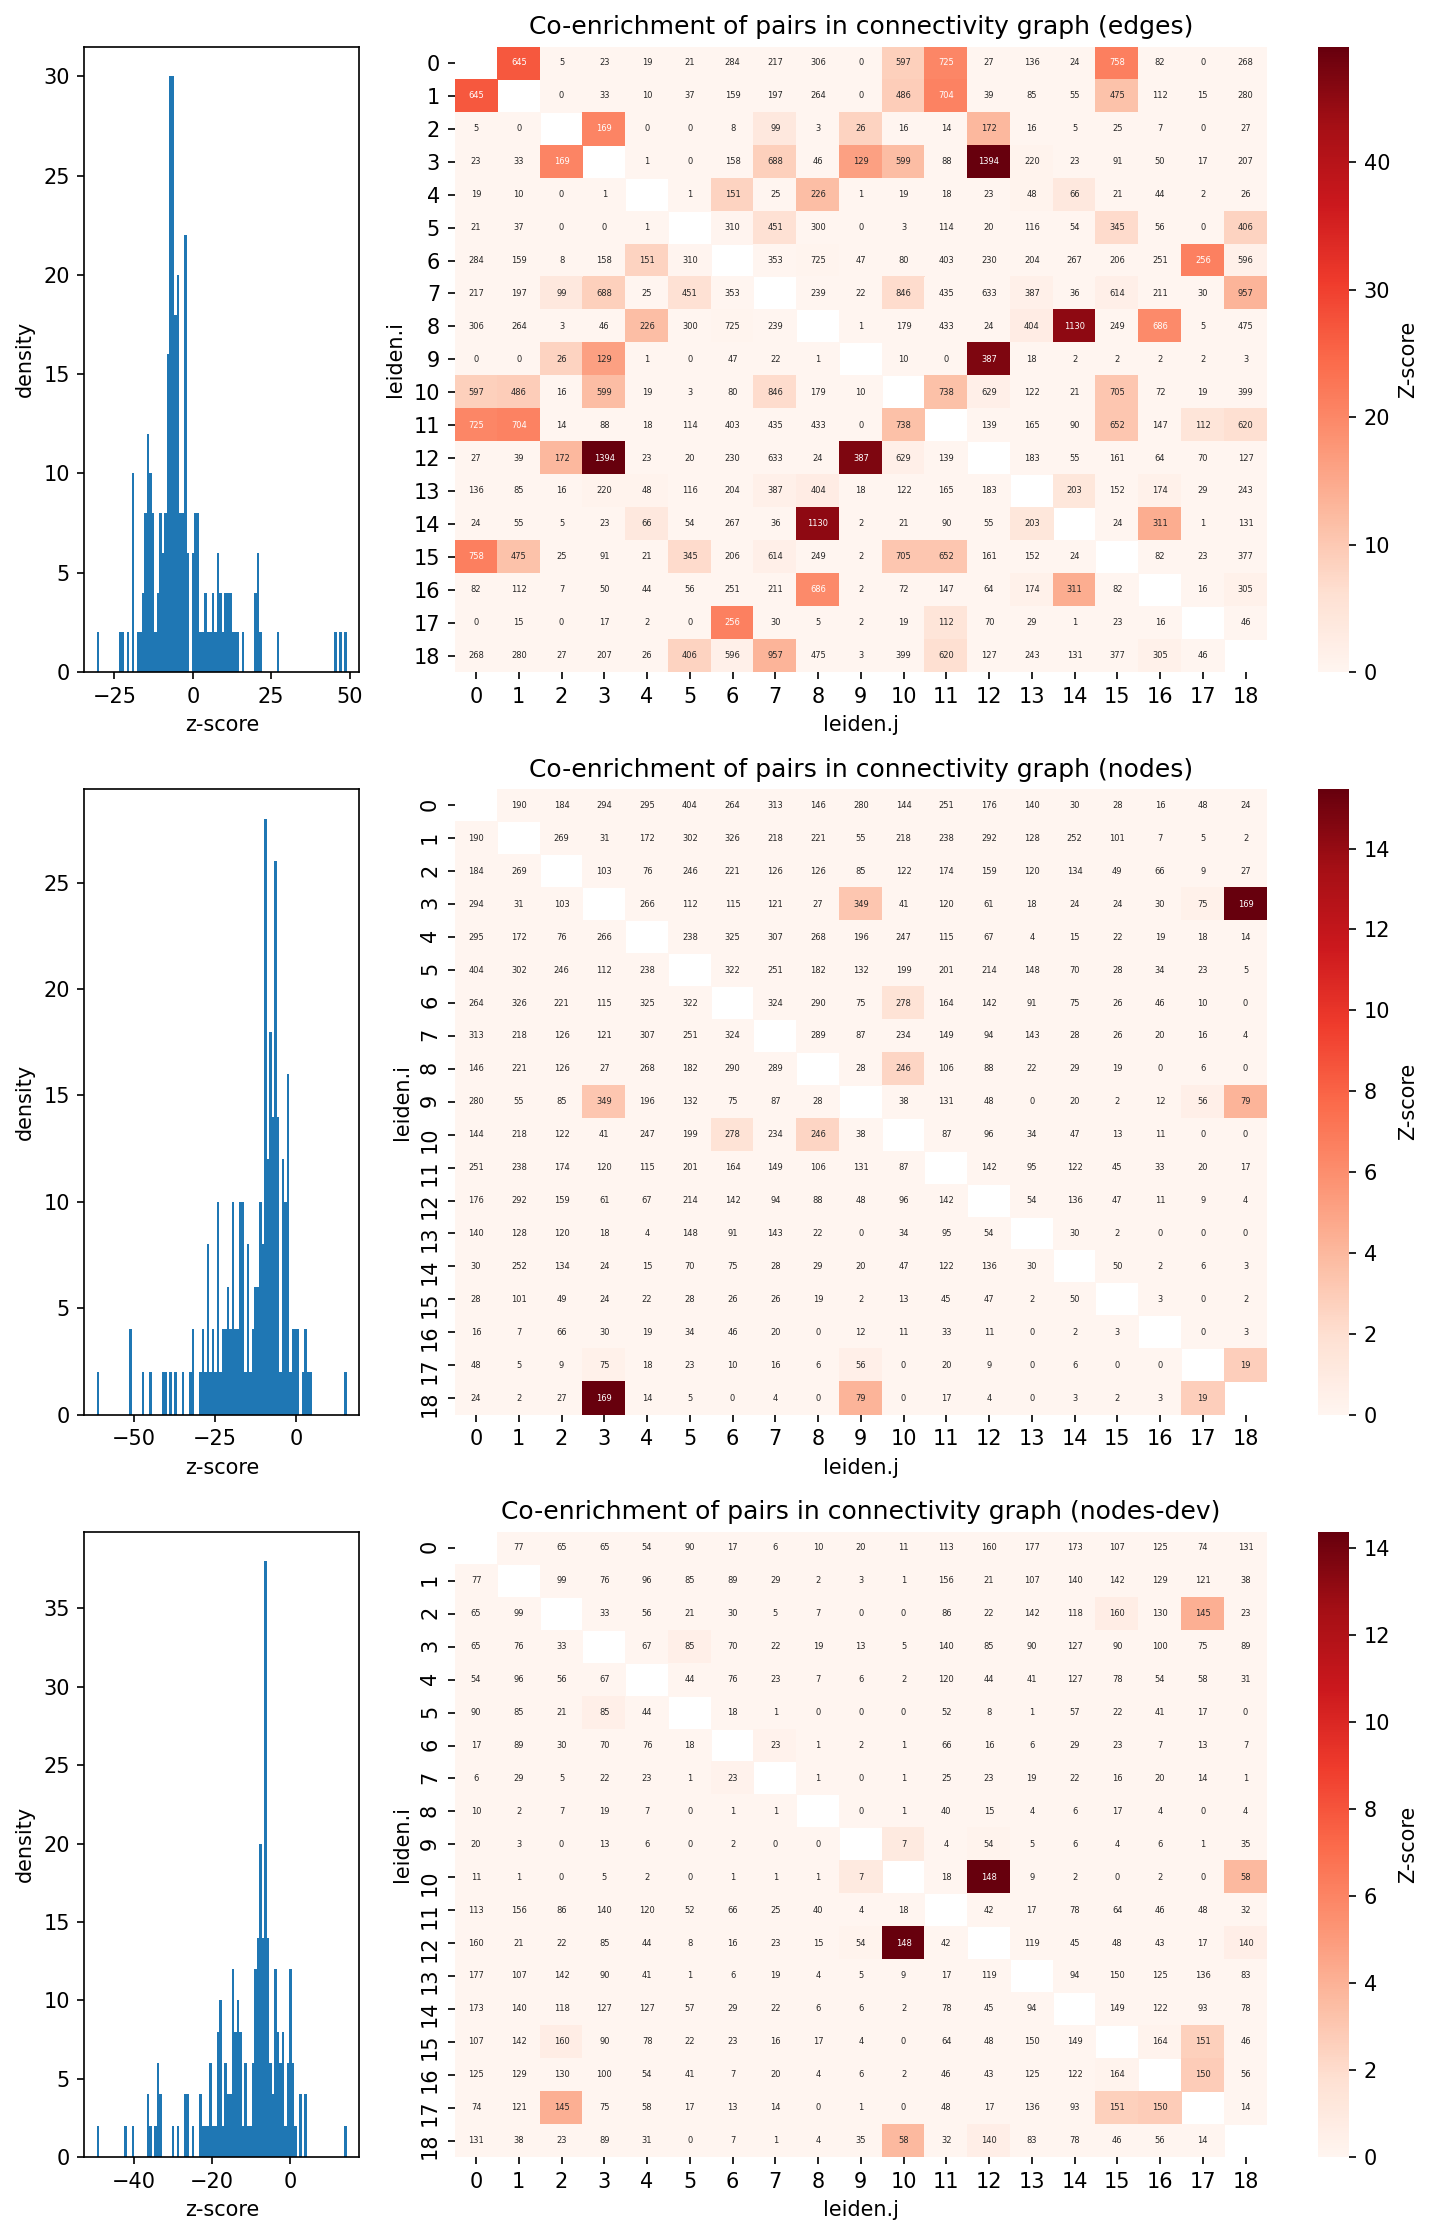

In [461]:
pi = 0
for df, lab in zip([edges, nodes, nodes_dev], ['edges', 'nodes', 'nodes-dev']):
    hm = df.pivot('leiden.i', 'leiden.j', 'z.score')
    annot = df.pivot('leiden.i', 'leiden.j', 'n.obs')

    plt.subplot2grid([3, 4], [pi, 0], rowspan=1, colspan=1)
    plt.hist(np.array(hm).flatten(), bins=100);
    plt.xlabel('z-score')
    plt.ylabel('density')

    vmax = max(hm.max())
    vmin = -5 # vmax
    # print(vmin, vmax)
    idx = hm.index.astype(int).sort_values().astype(int)
    # print(idx)

    plt.subplot2grid([3, 4], [pi, 1], rowspan=1, colspan=3)
    sns.heatmap(hm.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]],
                annot=annot.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]],
                fmt='.0f',
                cmap='Reds', vmin=0, vmax=vmax,
                cbar_kws={'label': 'Z-score'},
                annot_kws={'fontsize': 4}, xticklabels=True, yticklabels=True)
    plt.title('Co-enrichment of pairs in connectivity graph (%s)' % (lab))
    plt.tight_layout()
    pi += 1

### Check based on nodes clusters 3 and 18

In [ ]:
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin({'3', '18'}), adata.obs['leiden'], 'others')
sc.pl.spatial(adata, color = "leiden.query")

... storing 'leiden.query' as categorical


In [ ]:
g = sns.clustermap(hm.fillna(0),
                   cmap='Reds', vmin=0, vmax=vmax, cbar_kws={'label': 'Z-score'})
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.subplots_adjust(right=.5, bottom=.7)

load the data and calculate some basic metrics